In [13]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn_tda as tda
from sklearn.cluster import AgglomerativeClustering
np.random.seed(42)

In [14]:
# some helper functions. Feel free to modify them.

def sw_kernel(diags1, diags2):
    """ check more kernels at
     https://github.com/MathieuCarriere/sklearn-tda/blob/master/example/ex_diagrams.py

     :param: diags1: a list of np.array (shape (n, 2))
     :param diags2: a list of np.array (shape (m, 2))
     :return a np.array of shape n * m
    """
    SW = tda.SlicedWassersteinKernel(num_directions=100, bandwidth=1.)
    X = SW.fit(diags1)
    Y = SW.transform(diags2)
    return Y.T


def plot_kernel(kernel, title='Kernel'):
    plt.matshow(kernel)
    plt.title(title)
    plt.colorbar()
    plt.show()


def kernel2dist(kernel):
    """ convert kernel matrix to distance matrix """
    assert isinstance(kernel, np.ndarray)
    assert (kernel == kernel.T).all(), 'Your kernel is supposed to be symmetric'

    dist_matrix = 2 - 2 * kernel
    assert np.min(dist_matrix) >= 0, 'Dist Matrix is supposed to be postive'
    dist_matrix = np.sqrt(dist_matrix)
    return dist_matrix


def cluster(X):
    """ implement clustering algorithm to cluster persistence diagrams.
        see more examples at https://scikit-learn.org/stable/modules/clustering.html
    """
    clustering = AgglomerativeClustering(affinity='precomputed', linkage='average').fit(X)
    return clustering.labels_


# Generate persistence diagrams

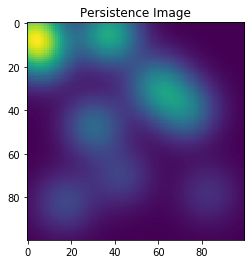

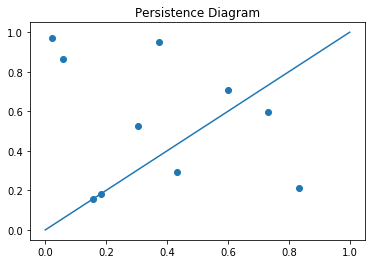

In [15]:
# generate 40 persistence diagrams. Note that I delibrately generate two types of diagrams that are quite different.
diags = [np.random.random((10, 2)) for _ in range(20)]
diags += [1 + np.random.random((10, 2)) for _ in range(20)]

# show one persistence diagram in the form of persistence image
PI = tda.PersistenceImage(bandwidth=.1, weight=lambda x: x[1], im_range=[0,1,0,1], resolution=[100,100])
pi = PI.fit_transform(diags[:1])
plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
plt.title("Persistence Image")
plt.show()

# plot the origianal diagram
plt.scatter(diags[0][:,0],diags[0][:,1])
plt.plot([0.,1.],[0.,1.])
plt.title("Persistence Diagram")
plt.show()

# Compute kernel for persistence diagrams

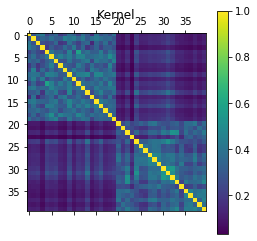

In [16]:
# compute sliced wasserstein kernels
kernel = sw_kernel(diags, diags)
plot_kernel(kernel, title='Kernel')

# Convert Kernel to Distance Matrix

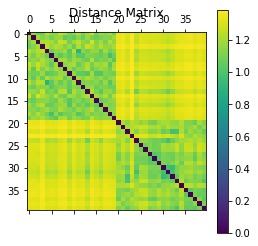

In [17]:
# plot distance matrix
dist = kernel2dist(kernel)
plot_kernel(dist, title='Distance Matrix')

# Cluster Persistence Diagrams

In [18]:
# cluster and print out labels. Since we knew there are two "types" of persistence diagrams by construction,
# we expect that clustering algorithm can differentiate them, which is indeed the case!
labels = cluster(dist)
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


# Visualize Clustering Tree 

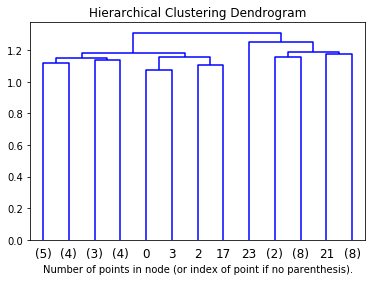

In [19]:
# modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = dist 
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='precomputed', linkage='average', distance_threshold=0, n_clusters=None)
# AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()